# Dataset Exploration

## Imports

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2
from PIL import Image
import pandas as pd
import random
import numpy as np

## EDA

In [3]:
DATASET_PATH = Path('../dataset/Data')

train_df = pd.read_csv(DATASET_PATH / 'train_paths.csv')
valid_df = pd.read_csv(DATASET_PATH / 'valid_paths.csv')
test_df = pd.read_csv(DATASET_PATH / 'test_paths.csv')

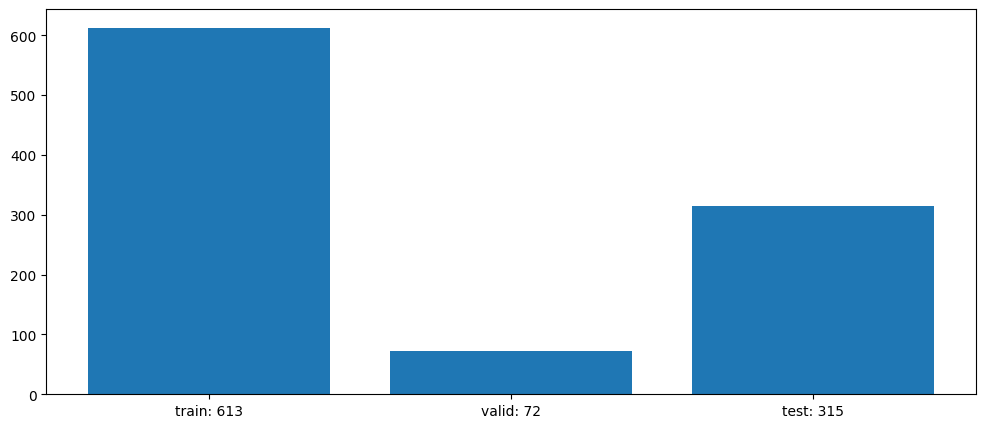

In [7]:
df_lens = [len(train_df), len(valid_df), len(test_df)]
plt.figure(figsize=(12, 5))
plt.bar([f'train: {len(train_df)}', f'valid: {len(valid_df)}', f'test: {len(test_df)}'], df_lens)
plt.show()

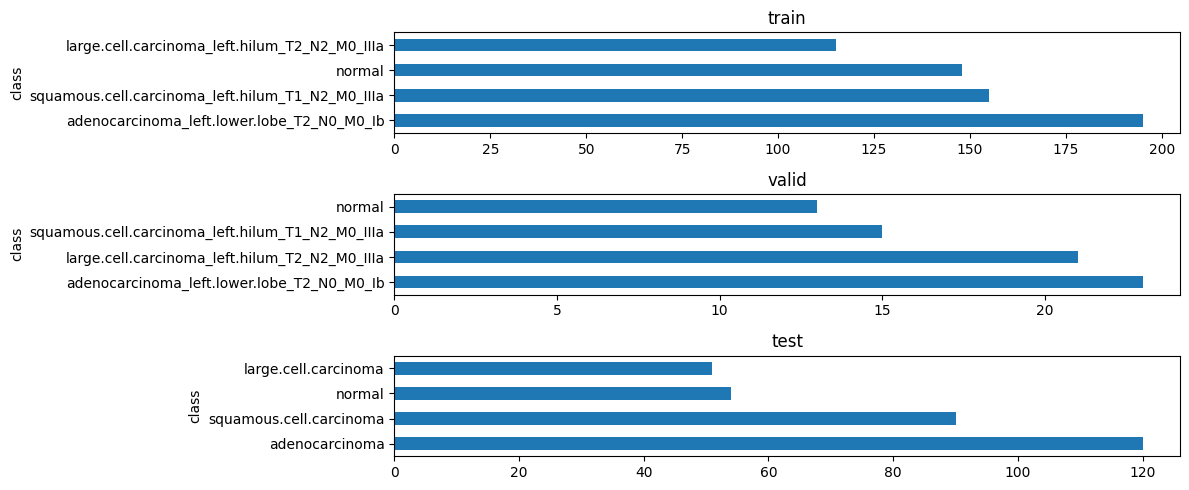

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.title('train')
train_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
# plt.show()
plt.subplot(3, 1, 2)
plt.title('valid')
valid_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
# plt.show()
plt.subplot(3, 1, 3)
plt.title('test')
test_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
plt.show()

> The class distribution on the training dataset is not balanced but it should be fine since we're using traditional methods. It seems that a lot of people that are in the dataset suffer from adenocarcinoma

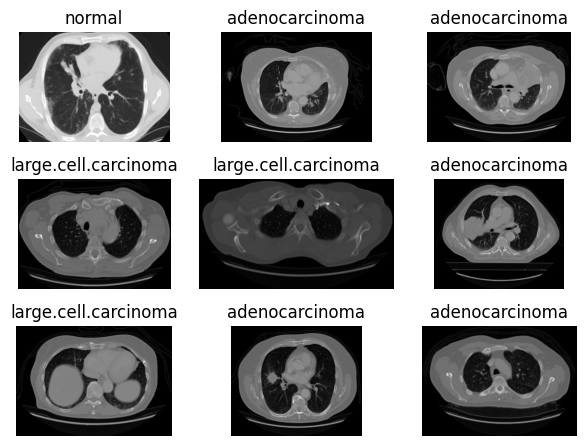

In [4]:
# 9 Random Images so we can know the dataset better

for i in range(9):
    random_data = random.choice(test_images)
    random_img = Image.open(random_data[0])
    random_label = random_data[1]
    plt.subplot(3, 3, i+1)
    plt.title(random_label)
    plt.imshow(random_img)
    plt.tight_layout()
    plt.axis(False)
plt.show()